In [1]:
#!pip install python-whois

In [2]:
#!pip install vt

In [3]:
#!pip install xgboost

In [5]:
#!pip install tld

In [1]:
import pandas as pd
import seaborn as sns
from sklearn import tree
import itertools
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import math
from collections import Counter
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import plot_roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
import os
import socket
import whois
from datetime import datetime
import time
from bs4 import BeautifulSoup
import urllib
import bs4
import os
import csv
from tld import get_tld, is_tld
from urllib.parse import urlparse
import os.path

In [2]:
os.chdir('C:\\Users\\vijay\\Desktop\\Python-programs')

In [3]:
os.getcwd()

'C:\\Users\\vijay\\Desktop\\Python-programs'

In [4]:
df=pd.read_csv('C:\\Users\\vijay\\Desktop\\Python-programs\\multiclass_set_randomized_whois_dataset.csv')
print(df.shape)
df.head()

(106230, 4)


url      type  Domain_Age  \
0  http://www.keve-kiserdo.hu/portal/index.php?op...      spam           0   
1                          www.agdealer.com/keystone  phishing           0   
2                            sbcspa.tripod.com/sbcs/  phishing           1   
3  hockeydraft.ca/players/profile.aspx?id=4132&na...    benign           0   
4        210.37.11.238/jm32/includes/site/config.bin   malware           0   

   Registrant_Country  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106230 entries, 0 to 106229
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   url                 106230 non-null  object
 1   type                106230 non-null  object
 2   Domain_Age          106230 non-null  int64 
 3   Registrant_Country  106230 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


In [6]:
df.type.value_counts()

malware     27424
phishing    26773
benign      26144
spam        25889
Name: type, dtype: int64

In [7]:
df.isnull().sum()

url                   0
type                  0
Domain_Age            0
Registrant_Country    0
dtype: int64

In [8]:
count = df.type.value_counts()
count

malware     27424
phishing    26773
benign      26144
spam        25889
Name: type, dtype: int64

In [9]:
df1=df.drop(['url'],axis=1)

In [10]:
df1

type  Domain_Age  Registrant_Country
0           spam           0                   1
1       phishing           0                   1
2       phishing           1                   1
3         benign           0                   1
4        malware           0                   1
...          ...         ...                 ...
106225  phishing           0                   1
106226      spam           1                   0
106227  phishing           0                   0
106228      spam           0                   1
106229    benign           1                   0

[106230 rows x 3 columns]

In [11]:
cross_tab_prop = pd.crosstab(index=df1['type'], columns=df1['Domain_Age'])
cross_tab_prop

Domain_Age     0      1
type                   
benign      2099  24045
malware     8233  19191
phishing    6740  20033
spam        2487  23402

In [13]:
cross_tab = pd.crosstab(index=df1['type'], columns=df1['Registrant_Country'])
cross_tab

Registrant_Country      0      1
type                            
benign              10632  15512
malware              3182  24242
phishing             3435  23338
spam                 4281  21608

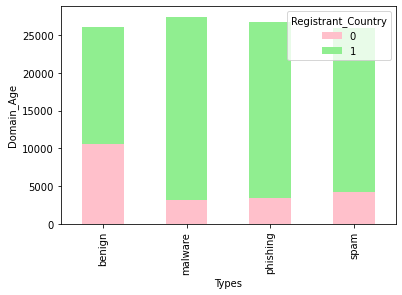

In [14]:
#plotting registrant country vs type lable. registrant country zero is selected few countries.
cross_tab.plot(kind='bar', stacked=True, color=['pink','lightgreen'])

plt.xlabel('Types')
plt.ylabel('Domain_Age')
plt.show()

In [15]:
#Feature Engineering

In [16]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [17]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [18]:
df['count.'] = df['url'].apply(lambda i: i.count('.'))
df.head()

url      type  Domain_Age  \
0  http://www.keve-kiserdo.hu/portal/index.php?op...      spam           0   
1                          www.agdealer.com/keystone  phishing           0   
2                            sbcspa.tripod.com/sbcs/  phishing           1   
3  hockeydraft.ca/players/profile.aspx?id=4132&na...    benign           0   
4        210.37.11.238/jm32/includes/site/config.bin   malware           0   

   Registrant_Country  use_of_ip  abnormal_url  count.  
0                   1          0             1       3  
1                   1          0             0       2  
2                   1          0             0       2  
3                   1          0             0       2  
4                   1          1             0       4

In [19]:
df['count-www'] = df['url'].apply(lambda i: i.count('www'))
df['count@'] = df['url'].apply(lambda i: i.count('@'))
df['count//'] = df['url'].apply(lambda i: i.count('//'))
df['count?'] = df['url'].apply(lambda i: i.count('?'))
df['count='] = df['url'].apply(lambda i: i.count('='))
df['count_comma'] = df['url'].apply(lambda i: i.count(','))
df['count*'] = df['url'].apply(lambda i: i.count('*'))
df['count+'] = df['url'].apply(lambda i: i.count('+'))
df['count!'] = df['url'].apply(lambda i: i.count('!'))
df['count%'] = df['url'].apply(lambda i: i.count('%'))
df['count-'] = df['url'].apply(lambda i: i.count('-'))
df['count_quote'] = df['url'].apply(lambda i: i.count('"'))
from urllib.parse import urlparse
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')
df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [20]:
df['count-https'] = df['url'].apply(lambda i : i.count('https'))
df['count-http'] = df['url'].apply(lambda i : i.count('http'))

In [21]:
#Length of URL
df['url_length'] = df['url'].apply(lambda i: len(str(i)))
#Hostname Length
df['hostname_length'] = df['url'].apply(lambda i: len(urlparse(i).netloc))

df.head()

url      type  Domain_Age  \
0  http://www.keve-kiserdo.hu/portal/index.php?op...      spam           0   
1                          www.agdealer.com/keystone  phishing           0   
2                            sbcspa.tripod.com/sbcs/  phishing           1   
3  hockeydraft.ca/players/profile.aspx?id=4132&na...    benign           0   
4        210.37.11.238/jm32/includes/site/config.bin   malware           0   

   Registrant_Country  use_of_ip  abnormal_url  count.  count-www  count@  \
0                   1          0             1       3          1       0   
1                   1          0             0       2          1       0   
2                   1          0             0       2          0       0   
3                   1          0             0       2          0       0   
4                   1          1             0       4          0       0   

   count//  ...  count%  count-  count_quote  count_dir  count_embed_domian  \
0        1  ...       0       2            0          2                   0   
1        0  ...       0       0            0          1                   0   
2        0  ...       0       0            0          2                   0   
3        0  ...       3       0            0          2                   0   
4        0  ...       0       0            0          4                   0   

   short_url  count-https  count-http  url_length  hostname_length  
0          0            0           1         123               19  
1          0            0           0          25                0  
2          0            0           0          23                0  
3          0            0           0          91                0  
4          0            0           0          43                0  

[5 rows x 26 columns]

In [22]:
def suspicious_words(url):
    match = re.search('urgent|bonanza|property|global|PayPal|advice|job|login|online|signin|heipdesk|delivery|bank|account|tax|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

In [23]:
df.tail()

url      type  \
106225           https://whatsapp-grupnew20.justdied.com/  phishing   
106226  http://www.resurrectionbellevue.org/index.php/...      spam   
106227  http://porquebiotecnologia.com.ar/components/c...  phishing   
106228  http://florsiris.com/index.php?option=com_jeve...      spam   
106229                     lovealocalbusiness.intuit.com/    benign   

        Domain_Age  Registrant_Country  use_of_ip  abnormal_url  count.  \
106225           0                   1          0             1       2   
106226           1                   0          0             1       3   
106227           0                   0          0             1       2   
106228           0                   1          0             1       3   
106229           1                   0          0             0       2   

        count-www  count@  count//  ...  count-  count_quote  count_dir  \
106225          0       0        1  ...       1            0          1   
106226          1       0        1  ...       0            0          2   
106227          0       0        1  ...       0            0          7   
106228          0       0        1  ...       0            0          1   
106229          0       0        0  ...       0            0          1   

        count_embed_domian  short_url  count-https  count-http  url_length  \
106225                   0          0            1           1          40   
106226                   0          0            0           1          53   
106227                   0          0            0           1          90   
106228                   0          0            0           1         105   
106229                   0          1            0           0          30   

        hostname_length  sus_url  
106225               31        0  
106226               28        0  
106227               26        1  
106228               13        0  
106229                0        0  

[5 rows x 27 columns]

In [24]:
#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [25]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['count-digits']= df['url'].apply(lambda i: digit_count(i))

In [26]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['count-letters']= df['url'].apply(lambda i: letter_count(i))

In [27]:
df.head()

url      type  Domain_Age  \
0  http://www.keve-kiserdo.hu/portal/index.php?op...      spam           0   
1                          www.agdealer.com/keystone  phishing           0   
2                            sbcspa.tripod.com/sbcs/  phishing           1   
3  hockeydraft.ca/players/profile.aspx?id=4132&na...    benign           0   
4        210.37.11.238/jm32/includes/site/config.bin   malware           0   

   Registrant_Country  use_of_ip  abnormal_url  count.  count-www  count@  \
0                   1          0             1       3          1       0   
1                   1          0             0       2          1       0   
2                   1          0             0       2          0       0   
3                   1          0             0       2          0       0   
4                   1          1             0       4          0       0   

   count//  ...  count-https  count-http  url_length  hostname_length  \
0        1  ...            0           1         123               19   
1        0  ...            0           0          25                0   
2        0  ...            0           0          23                0   
3        0  ...            0           0          91                0   
4        0  ...            0           0          43                0   

   sus_url  fd_length   tld  tld_length  count-digits  count-letters  
0        0          6    hu           2             8             92  
1        0          8  None          -1             0             22  
2        0          4  None          -1             0             19  
3        0          7  None          -1            10             68  
4        0          4  None          -1            12             23  

[5 rows x 32 columns]

In [28]:
df = df.drop("tld",1)

C:\Users\vijay\AppData\Local\Temp\ipykernel_22916\2551734815.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("tld",1)


In [29]:
df["type"].value_counts()

malware     27424
phishing    26773
benign      26144
spam        25889
Name: type, dtype: int64

In [30]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

1    27424
2    26773
0    26144
3    25889
Name: type_code, dtype: int64

In [31]:
df.shape

(106230, 32)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106230 entries, 0 to 106229
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   url                 106230 non-null  object
 1   type                106230 non-null  object
 2   Domain_Age          106230 non-null  int64 
 3   Registrant_Country  106230 non-null  int64 
 4   use_of_ip           106230 non-null  int64 
 5   abnormal_url        106230 non-null  int64 
 6   count.              106230 non-null  int64 
 7   count-www           106230 non-null  int64 
 8   count@              106230 non-null  int64 
 9   count//             106230 non-null  int64 
 10  count?              106230 non-null  int64 
 11  count=              106230 non-null  int64 
 12  count_comma         106230 non-null  int64 
 13  count*              106230 non-null  int64 
 14  count+              106230 non-null  int64 
 15  count!              106230 non-null  int64 
 16  co

In [33]:
df['sus_url'].value_counts()



0    99946
1     6284
Name: sus_url, dtype: int64

In [34]:
df.describe()

Domain_Age  Registrant_Country      use_of_ip   abnormal_url  \
count  106230.000000       106230.000000  106230.000000  106230.000000   
mean        0.815881            0.797327       0.055286       0.632119   
std         0.387583            0.401993       0.228538       0.482231   
min         0.000000            0.000000       0.000000       0.000000   
25%         1.000000            1.000000       0.000000       0.000000   
50%         1.000000            1.000000       0.000000       1.000000   
75%         1.000000            1.000000       0.000000       1.000000   
max         1.000000            1.000000       1.000000       1.000000   

              count.      count-www         count@        count//  \
count  106230.000000  106230.000000  106230.000000  106230.000000   
mean        2.494154       0.313819       0.006213       0.635715   
std         1.208513       0.466111       0.083005       0.491049   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.000000       0.000000       0.000000   
50%         2.000000       0.000000       0.000000       1.000000   
75%         3.000000       1.000000       0.000000       1.000000   
max        42.000000       4.000000       4.000000       9.000000   

              count?         count=  ...    count-https     count-http  \
count  106230.000000  106230.000000  ...  106230.000000  106230.000000   
mean        0.246644       0.819910  ...       0.114205       0.638040   
std         0.440863       1.830862  ...       0.322996       0.496922   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...       0.000000       0.000000   
50%         0.000000       0.000000  ...       0.000000       1.000000   
75%         0.000000       0.000000  ...       0.000000       1.000000   
max        20.000000      51.000000  ...       5.000000       9.000000   

          url_length  hostname_length        sus_url      fd_length  \
count  106230.000000    106230.000000  106230.000000  106230.000000   
mean       63.438596        11.007823       0.059155       9.970329   
std        44.892604         9.907179       0.235915      13.205280   
min         1.000000         0.000000       0.000000       0.000000   
25%        34.000000         0.000000       0.000000       4.000000   
50%        51.000000        12.000000       0.000000       7.000000   
75%        81.000000        19.000000       0.000000      10.000000   
max      1641.000000       179.000000       1.000000     408.000000   

          tld_length   count-digits  count-letters      type_code  
count  106230.000000  106230.000000  106230.000000  106230.000000  
mean        1.255634       6.891227      45.534811       1.493335  
std         2.406801      12.080508      32.963025       1.108872  
min        -1.000000       0.000000       0.000000       0.000000  
25%        -1.000000       0.000000      25.000000       1.000000  
50%         2.000000       3.000000      37.000000       1.000000  
75%         3.000000       9.000000      59.000000       2.000000  
max        39.000000     738.000000    1301.000000       3.000000  

[8 rows x 30 columns]

In [35]:
df.columns

Index(['url', 'type', 'Domain_Age', 'Registrant_Country', 'use_of_ip',
       'abnormal_url', 'count.', 'count-www', 'count@', 'count//', 'count?',
       'count=', 'count_comma', 'count*', 'count+', 'count!', 'count%',
       'count-', 'count_quote', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'url_length', 'hostname_length', 'sus_url',
       'fd_length', 'tld_length', 'count-digits', 'count-letters',
       'type_code'],
      dtype='object')

In [36]:
df.groupby('type').max()

url  Domain_Age  \
type                                                                      
benign    zzounds.com/cat--Bass-Guitars-Amps-and-Effects...           1   
malware                                  zvbotw96uflyag.bid           1   
phishing               þUß ï5ÐºÐã4ìýÕÅçÒJ.*/dB2
ô®Y¹           1   
spam           http://zshsq.com/view/html/index.html?3.html           1   

          Registrant_Country  use_of_ip  abnormal_url  count.  count-www  \
type                                                                       
benign                     1          0             1      21          1   
malware                    1          1             1      18          2   
phishing                   1          1             1      42          4   
spam                       1          0             1      11          2   

          count@  count//  count?  ...  count-https  count-http  url_length  \
type                               ...                                        
benign         2        2      20  ...            3           3        1040   
malware        1        3       3  ...            1           3         378   
phishing       4        9       5  ...            5           9        1641   
spam           0        1       4  ...            0           2         302   

          hostname_length  sus_url  fd_length  tld_length  count-digits  \
type                                                                      
benign                 21        1        408           6           664   
malware               149        1        259          26           106   
phishing              179        1        256          39           738   
spam                   49        1        223           7           132   

          count-letters  type_code  
type                                
benign              290          0  
malware             253          1  
phishing           1301          2  
spam                253          3  

[4 rows x 31 columns]

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106230 entries, 0 to 106229
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   url                 106230 non-null  object
 1   type                106230 non-null  object
 2   Domain_Age          106230 non-null  int64 
 3   Registrant_Country  106230 non-null  int64 
 4   use_of_ip           106230 non-null  int64 
 5   abnormal_url        106230 non-null  int64 
 6   count.              106230 non-null  int64 
 7   count-www           106230 non-null  int64 
 8   count@              106230 non-null  int64 
 9   count//             106230 non-null  int64 
 10  count?              106230 non-null  int64 
 11  count=              106230 non-null  int64 
 12  count_comma         106230 non-null  int64 
 13  count*              106230 non-null  int64 
 14  count+              106230 non-null  int64 
 15  count!              106230 non-null  int64 
 16  co

In [38]:
#create csv file from feature engineered dataframe for MLPclassifier hyper parameter fine tuning.
#df.to_csv('multiclass_set_randomized_features_with_whois.csv')

In [39]:
#Predictor Variables
X = df[['Domain_Age','Registrant_Country','use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count//', 'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters', 'count_comma', 'count*',
       'count+', 'count!','count_quote']]

#Target Variable
y = df['type_code']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [41]:
# 1st Model: XGBoost Classifier

model = xgb.XGBClassifier(n_estimators= 100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))


score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5229
           1       0.98      0.96      0.97      5485
           2       0.94      0.89      0.91      5354
           3       0.96      0.99      0.97      5178

    accuracy                           0.95     21246
   macro avg       0.95      0.95      0.95     21246
weighted avg       0.95      0.95      0.95     21246

accuracy:   0.950


In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


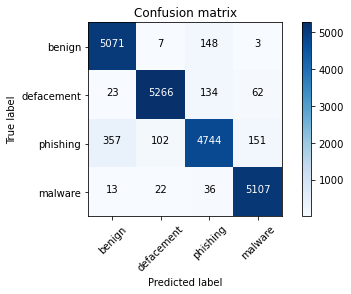

In [43]:
cm=confusion_matrix(y_test,y_pred,labels=[0,1,2,3])

plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [44]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=1)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print(classification_report(y_test,y_pred))

score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)


              precision    recall  f1-score   support

           0       0.90      0.97      0.94      5229
           1       0.92      0.95      0.94      5485
           2       0.92      0.85      0.88      5354
           3       0.96      0.93      0.94      5178

    accuracy                           0.92     21246
   macro avg       0.93      0.92      0.92     21246
weighted avg       0.93      0.92      0.92     21246

accuracy:   0.925


C:\Users\vijay\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion matrix, without normalization


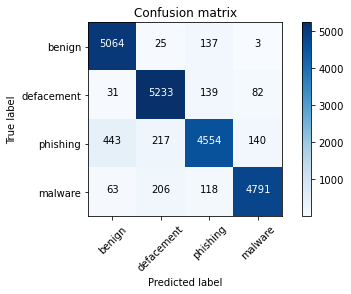

In [45]:
cm=confusion_matrix(y_test,y_pred,labels=[0,1,2,3])

plot_confusion_matrix(cm,classes=['benign', 'defacement','phishing','malware'])

In [46]:
#Measure execution time of model
import time

#Start time
st = time.time()

# 1st Model: XGBoost Classifier

model = xgb.XGBClassifier(n_estimators= 100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

#end time
et = time.time()

# get the execution time
res = et - st
final_res = res * 1000
print('Program Execution time:', final_res, 'milliseconds')

Program Execution time: 6566.811561584473 milliseconds


In [47]:
#Measure execution time of model
import time

#Start time
st = time.time()

#MLP classifier
mlp = MLPClassifier(random_state=1)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

#end time
et = time.time()

# get the execution time
res = et - st
final_res = res * 1000
print('Program Execution time:', final_res, 'milliseconds')

Program Execution time: 63258.13388824463 milliseconds


C:\Users\vijay\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
